# Physics-Informed GAN for Battery Temperature Generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Simulate data
np.random.seed(42)
n_samples = 500
X = np.array([
    np.sin(np.linspace(0, 2*np.pi, 50)) + np.random.normal(0, 0.1, 50)
    for _ in range(n_samples)
])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
tensor_data = torch.tensor(X_scaled, dtype=torch.float32)

In [3]:
# Dataset
class TempDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

loader = DataLoader(TempDataset(tensor_data), batch_size=32, shuffle=True)

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.model(z)

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [6]:
# Physics-informed losses
def non_negative_loss(generated, min_value=0.0):
    return torch.mean(torch.clamp(min_value - generated, min=0))

def smoothness_loss(generated):
    diff = generated[:, 1:] - generated[:, :-1]
    return torch.mean(diff**2)

def upper_bound_loss(generated, max_value=1.0):
    return torch.mean(torch.clamp(generated - max_value, min=0))

def physics_consistency_loss(generated, min_temp=0.0, max_temp=1.0, alpha=1.0, beta=1.0, gamma=1.0):
    return alpha * non_negative_loss(generated, min_temp) + \
           beta * smoothness_loss(generated) + \
           gamma * upper_bound_loss(generated, max_temp)

In [7]:
# Training
G = Generator(20, 50)
D = Discriminator(50)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)

G_losses, D_losses = [], []

for epoch in range(10):
    for real in loader:
        batch = real.size(0)
        real_labels = torch.ones((batch, 1))
        fake_labels = torch.zeros((batch, 1))

        # Train Discriminator
        z = torch.randn(batch, 20)
        fake = G(z).detach()
        loss_real = loss_fn(D(real), real_labels)
        loss_fake = loss_fn(D(fake), fake_labels)
        loss_D = (loss_real + loss_fake) / 2
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch, 20)
        gen = G(z)
        loss_G = loss_fn(D(gen), real_labels)
        physics_loss = physics_consistency_loss(gen)
        total_loss_G = loss_G + physics_loss

        opt_G.zero_grad()
        total_loss_G.backward()
        opt_G.step()

        G_losses.append(total_loss_G.item())
        D_losses.append(loss_D.item())

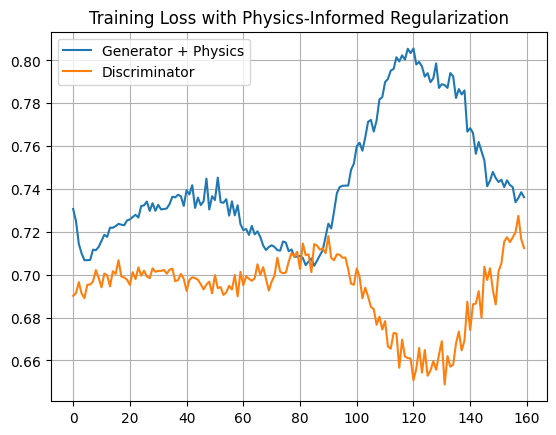

In [8]:
# Plot losses
plt.plot(G_losses, label='Generator + Physics')
plt.plot(D_losses, label='Discriminator')
plt.legend()
plt.title('Training Loss with Physics-Informed Regularization')
plt.grid(True)
plt.show()

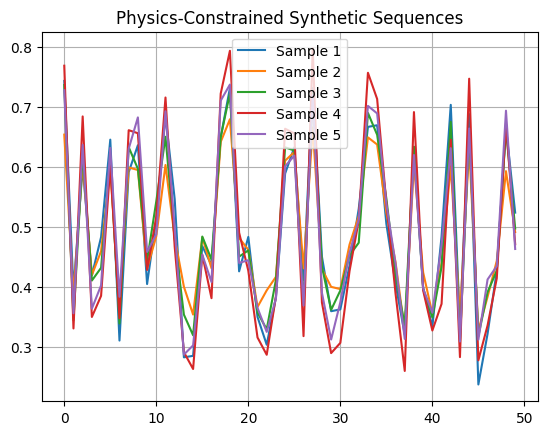

In [10]:
# Generate and visualize samples
z = torch.randn(5, 20)
samples = G(z).detach().numpy()
for i, s in enumerate(samples):
    plt.plot(s, label=f'Sample {i+1}')
plt.title('Physics-Constrained Synthetic Sequences')
plt.legend()
plt.grid(True)
plt.show()